In [1]:
import pandas as pd
import numpy as np
from numba import jit
import time
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from downcast import reduce
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Large dataset, use 2 methods to save memory
@jit
def reduce_mem_usage(df, verbose=True, method='downcast'):
    start = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    if method == 'downcast':
        df = reduce(df)
    else:
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction) and time is '.format(end_mem, 100 * (
                    start_mem - end_mem) / start_mem) + str(time.time() - start))
    return df

In [3]:
# missing data check
@jit
def missing_data_check(data):
    missing_data = pd.DataFrame()
    missing_data.index = data.columns
    begin = time.time()
    percent = data.isnull().sum() / data.isnull().count()
    missing_data['missing rate'] = percent.values
    last = time.time()
    print('Finished checking data and time is {}s'.format(str(last - begin)))
    return missing_data

In [4]:
#Read data
calendar = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/calendar.csv')
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = reduce_mem_usage(calendar, method='aa')
sell_prices = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)
sales_train = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/sales_train_evaluation.csv')
sales_train = reduce_mem_usage(sales_train)
# submission = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/sample_submission.csv')
# submission = reduce_mem_usage(submission)

Mem. usage decreased to  0.12 Mb (41.9% reduction) and time is 0.003989219665527344
Mem. usage decreased to 45.76 Mb (78.1% reduction) and time is 0.8128960132598877
Mem. usage decreased to 96.30 Mb (78.7% reduction) and time is 123.0042450428009


In [5]:
missing_data_check(calendar)

Finished checking data and time is 0.004977226257324219s


,missing rate
date,0.000000
wm_yr_wk,0.000000
weekday,0.000000
wday,0.000000
month,0.000000
year,0.000000
d,0.000000
event_name_1,0.917725
event_type_1,0.917725
event_name_2,0.997461


In [6]:
missing_data_check(sell_prices)

Finished checking data and time is 0.10579419136047363s


,missing rate
store_id,0.0
item_id,0.0
wm_yr_wk,0.0
sell_price,0.0


In [7]:
missing_data_check(sales_train).sum()

Finished checking data and time is 0.722156286239624s


missing rate    0.0
dtype: float64

## Calendar

In [8]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [9]:
# get all the event types
calendar['event_type_1'].value_counts()

Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

In [10]:
calendar['event_type_2'].value_counts()

Cultural     4
Religious    1
Name: event_type_2, dtype: int64

In [11]:
#Names of Each Events with their counts
calendar['event_name_1'].value_counts()

SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: event_name_1, dtype: int64

In [12]:
calendar['event_name_2'].value_counts()

Father's day      2
Easter            1
Cinco De Mayo     1
OrthodoxEaster    1
Name: event_name_2, dtype: int64

In [13]:
# Encoding Snap and Month features
calendar = calendar.fillna('no_event')
snap = ['snap_CA', 'snap_TX', 'snap_WI']
for i in snap:
    calendar[i] = calendar[i].replace(0, 'no_snap')
    calendar[i] = calendar[i].replace(1, 'snap')
calendar_month = calendar['month']
month = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
for i in range(len(month)):
    calendar['month'] = calendar['month'].replace(i + 1, month[i])
calendar['month1'] = calendar_month

In [14]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,month1
0,2011-01-29,11101,Saturday,1,Jan,2011,d_1,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1
1,2011-01-30,11101,Sunday,2,Jan,2011,d_2,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1
2,2011-01-31,11101,Monday,3,Jan,2011,d_3,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1
3,2011-02-01,11101,Tuesday,4,Feb,2011,d_4,no_event,no_event,no_event,no_event,snap,snap,no_snap,2
4,2011-02-02,11101,Wednesday,5,Feb,2011,d_5,no_event,no_event,no_event,no_event,snap,no_snap,snap,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,June,2016,d_1965,no_event,no_event,no_event,no_event,no_snap,snap,snap,6
1965,2016-06-16,11620,Thursday,6,June,2016,d_1966,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,6
1966,2016-06-17,11620,Friday,7,June,2016,d_1967,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,6
1967,2016-06-18,11621,Saturday,1,June,2016,d_1968,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,6


In [15]:
#Adding feature 'is_weekend' which tells about that day is weekend or not
f=lambda x: 1 if x<=2 else 0
calendar['is_weekend']=calendar['wday'].map(f) 
calendar['is_weekend']=calendar['is_weekend'].astype(np.int8)

## Sales

In [16]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


## Sell Price

In [17]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [18]:
start = time.time()
df = pd.melt(sales_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='demand')
df = reduce_mem_usage(df)
print('time used: {}s'.format(str(time.time()-start)))
df

Mem. usage decreased to 678.68 Mb (33.3% reduction) and time is 3.0074636936187744
time used: 7.665066242218018s


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0


In [19]:
start = time.time()
df = pd.merge(df, calendar, on='d', how='left')
print('time used: {}s'.format(str(time.time()-start)))
df = reduce_mem_usage(df)
start1 = time.time()
df = pd.merge(df, sell_prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
print('time used: {}s'.format(str(time.time()-start1)))
df = reduce_mem_usage(df)
df['cost'] = df.demand * df.sell_price
df = reduce_mem_usage(df)
gc.collect()

time used: 31.19549798965454s
Mem. usage decreased to 2484.75 Mb (61.0% reduction) and time is 33.74974536895752
time used: 13.033753633499146s
Mem. usage decreased to 2597.62 Mb (0.0% reduction) and time is 1.4770927429199219
Mem. usage decreased to 2710.50 Mb (4.0% reduction) and time is 2.1712393760681152


24

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 25 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   demand        int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         category      
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       category      
 19  snap_TX       category      
 20  snap_WI       category      
 21  month1        int8          
 22  is_weekend    int8          
 23  sell_price    float16       
 

In [21]:
start = time.time()
df = df.dropna().reset_index(drop=True)
print('time used: {}s'.format(str(time.time()-start)))
df = reduce_mem_usage(df)
df

time used: 8.26969289779663s
Mem. usage decreased to 1789.80 Mb (0.0% reduction) and time is 1.4002983570098877


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,month1,is_weekend,sell_price,cost
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1,0.459961,5.519531
1,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1,1.559570,3.119141
2,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1,3.169922,0.000000
3,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1,5.980469,0.000000
4,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4,2011-01-29,11101,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1,0.700195,2.800781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46881672,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,5,1,2.980469,2.980469
46881673,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,5,1,2.480469,0.000000
46881674,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,5,1,3.980469,7.960938
46881675,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,no_event,no_event,no_event,no_snap,no_snap,no_snap,5,1,1.280273,0.000000


## Item counts in each store and category

Text(0.5, 1.0, 'Items in each store')

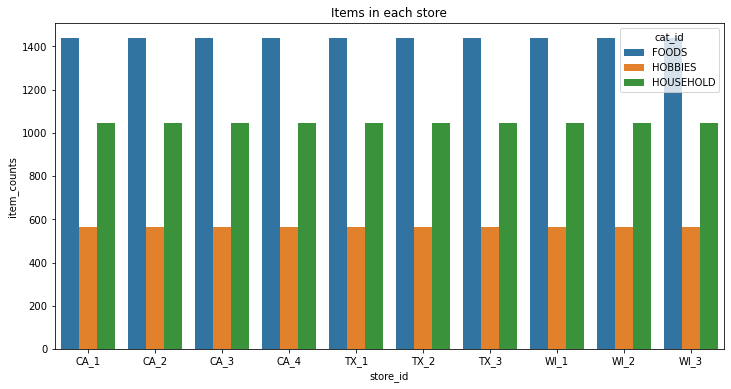

In [22]:
item_counts = sales_train.groupby(['store_id', 'cat_id']).agg({'item_id':'nunique'}).reset_index()
item_counts.columns = ['store_id', 'cat_id', 'item_counts']
plt.figure(figsize=(12, 6))
p=sns.barplot(data=item_counts, x='store_id', y='item_counts', hue='cat_id')
p.set_title('Items in each store')

Text(0.5, 1.0, 'Items in each category')

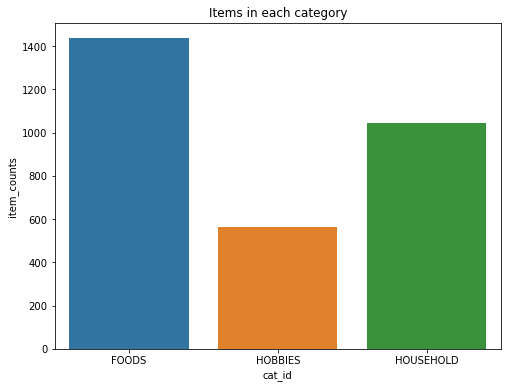

In [23]:
plt.figure(figsize=(8, 6))
p=sns.barplot(data=item_counts, x='cat_id', y='item_counts')
p.set_title('Items in each category')

In [24]:
sales_by_date = sales_train.loc[:, "d_1":].T.merge(calendar, left_index=True, right_on='d', how='left').set_index('date')

In [25]:
sales_by_date.head()

,0,1,2,3,4,5,6,7,8,9,...,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,month1,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,d_1,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,d_2,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,1
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,d_3,no_event,no_event,no_event,no_event,no_snap,no_snap,no_snap,1,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,d_4,no_event,no_event,no_event,no_event,snap,snap,no_snap,2,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,d_5,no_event,no_event,no_event,no_event,snap,no_snap,snap,2,0


## Plot the sales over time

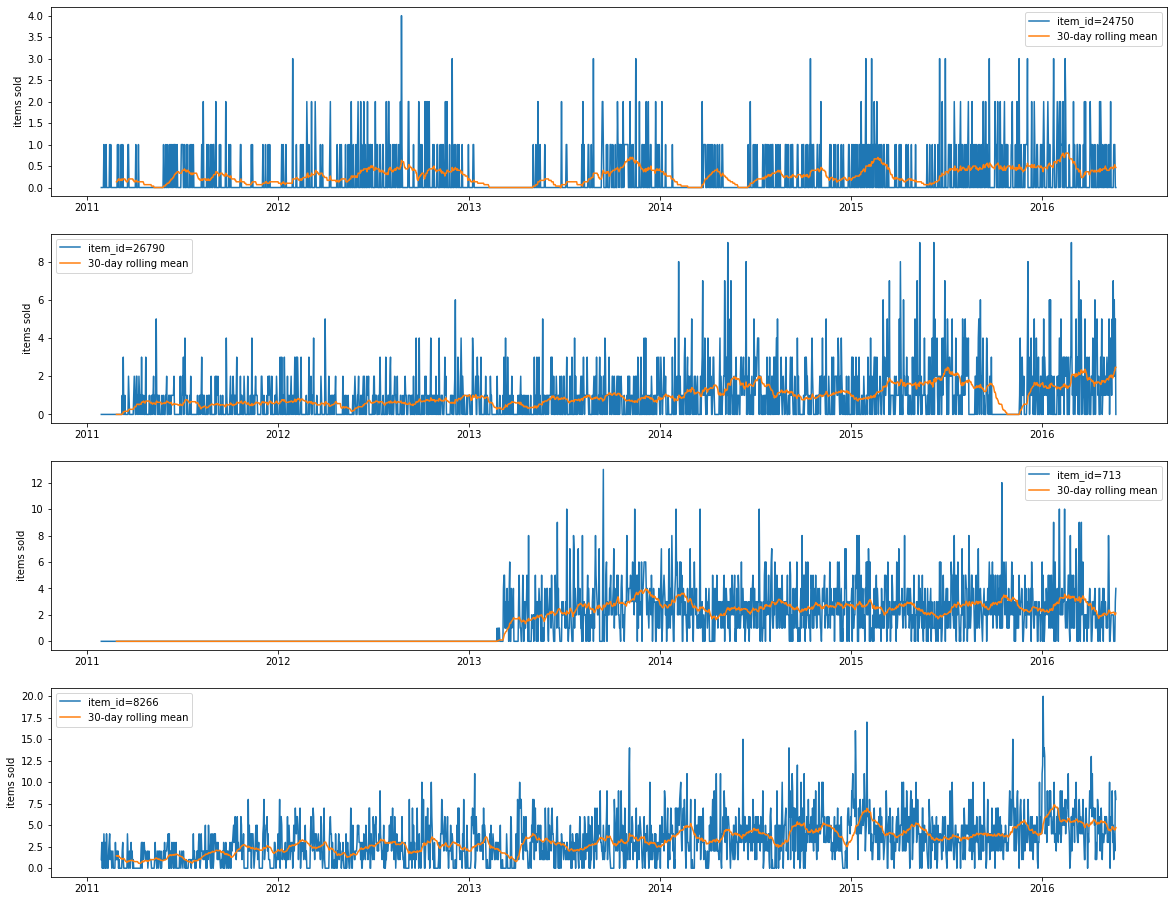

In [26]:
col=list(sales_train.loc[:, "d_1":].T.columns)
sample_items = random.sample(col, 4)

fig, axes = plt.subplots(len(sample_items), 1, figsize=(20, 16))
for i, sample_item in enumerate(sample_items):
    axes[i].plot(sales_by_date.index, sales_by_date[sample_item], label='item_id={}'.format(sample_item))
    axes[i].plot(sales_by_date.index, sales_by_date[sample_item].rolling(30).mean(), label='30-day rolling mean')
    axes[i].set_ylabel('items sold')
    axes[i].legend()

In [27]:
@jit
def find_first_non_zero_value(data, columns):
    first_non_zero=[]
    for i in columns:
        first_non_zero.append(np.nonzero(data[i].values)[0][0])
    first_non_zero=pd.DataFrame(first_non_zero)
    return first_non_zero

In [28]:
non_zero=find_first_non_zero_value(sales_by_date, col)
non_zero.describe()

,0
count,30490.000000
mean,406.194490
std,477.176658
min,0.000000
25%,1.000000
50%,159.000000
75%,766.000000
max,1845.000000


In [29]:
data = non_zero[non_zero[0] >= int(np.floor(non_zero[0].quantile(0.75)))]
data.describe()

,0
count,7638.000000
mean,1121.920136
std,235.753884
min,766.000000
25%,912.000000
50%,1121.000000
75%,1271.000000
max,1845.000000


In [30]:
def patch1(bar, ax):
    # https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
    for p in bar.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate('{}%'.format(height), (x + width / 2, y + height * 1.02), ha='center', fontsize=14)

In [31]:
def patch2(a, ax):
    # https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
    for p in a.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate('{:.2f}'.format(height), (x + width / 2, y + height * 1.02), ha='center', fontsize=13)

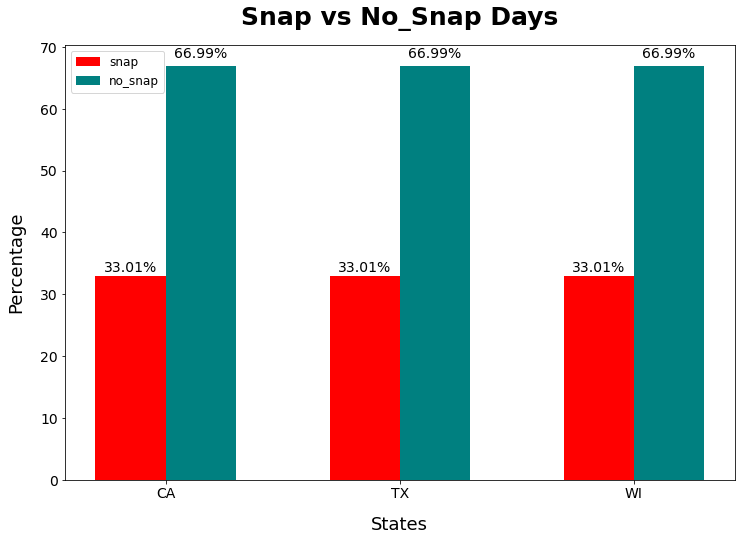

In [32]:
l1 = []  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
l2 = []
l3 = []
l1 = np.unique(calendar[calendar['snap_CA'] == 'snap']['d'].tolist())
l2 = np.unique(calendar[calendar['snap_TX'] == 'snap']['d'].tolist())
l3 = np.unique(calendar[calendar['snap_WI'] == 'snap']['d'].tolist())
labels = ['CA', 'TX', 'WI']
snap = [np.round((len(l1) / calendar.shape[0] * 100), 2), np.round((len(l2) / calendar.shape[0] * 100), 2),
        np.round((len(l3) / calendar.shape[0] * 100), 2)]
no_snap = [np.round((100 - (len(l1) / calendar.shape[0] * 100)), 2),
           np.round((100 - (len(l2) / calendar.shape[0] * 100)), 2),
           np.round((100 - (len(l3) / calendar.shape[0] * 100)), 2)]
x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 8))
bar1 = ax.bar(x - width / 2, snap, width, label='snap', color='red')
bar2 = ax.bar(x + width / 2, no_snap, width, label='no_snap', color='teal')
ax.set_ylabel('Percentage', fontsize=18, labelpad=15)
ax.set_xlabel('States', fontsize=18, labelpad=15)
ax.set_title('Snap vs No_Snap Days', loc='center', fontsize=25, pad='20', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=12)
patch1(bar1, ax)
patch1(bar2, ax)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

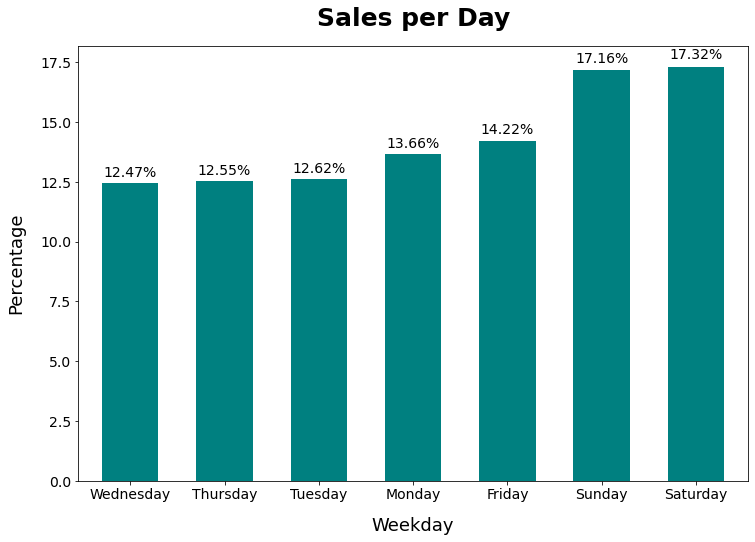

In [33]:
d = df[['weekday', 'demand']]
d = d.groupby(by='weekday').sum('demand').reset_index()
d['percent'] = np.round(d['demand'] / d['demand'].sum() * 100, 2)
d = d.sort_values('percent')
fig, axes = plt.subplots(figsize=(12, 8))
a = d.plot(kind='bar', x='weekday', y='percent', width=0.6, ax=axes, color='teal')
patch1(a, axes)
plt.title('Sales per Day', loc='center', fontsize=25, pad='20', fontweight='bold')
axes.set_ylabel('Percentage', fontsize=18, labelpad=15)
axes.set_xlabel('Weekday', fontsize=18, labelpad=15)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
axes.get_legend().remove()
plt.show()

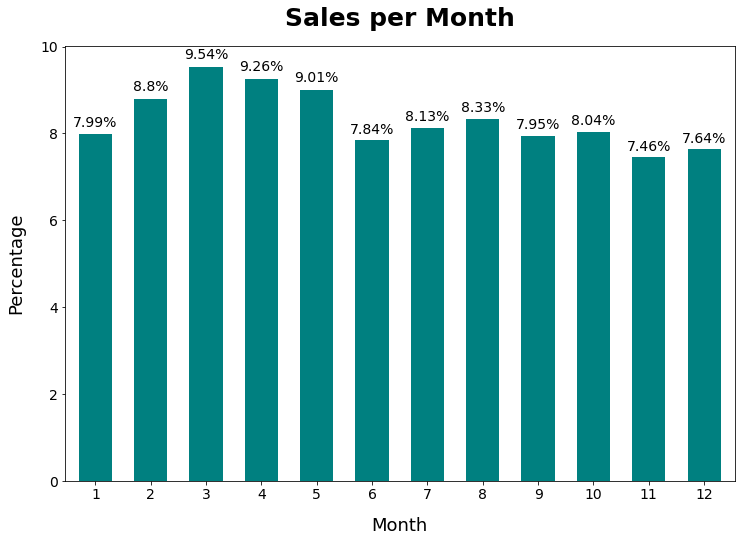

In [35]:
d = df[['month1', 'demand']]
d = d.groupby(by='month1').sum('demand').reset_index()
d['percent'] = np.round(d['demand'] / d['demand'].sum() * 100, 2)
fig, axes = plt.subplots(figsize=(12, 8))
a = d.plot(kind='bar', x='month1', y='percent', width=0.6, ax=axes, color='teal')
patch1(a, axes)
plt.title('Sales per Month', loc='center', fontsize=25, pad='20', fontweight='bold')
axes.set_ylabel('Percentage', fontsize=18, labelpad=15)
axes.set_xlabel('Month', fontsize=18, labelpad=15)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
axes.get_legend().remove()
plt.show()

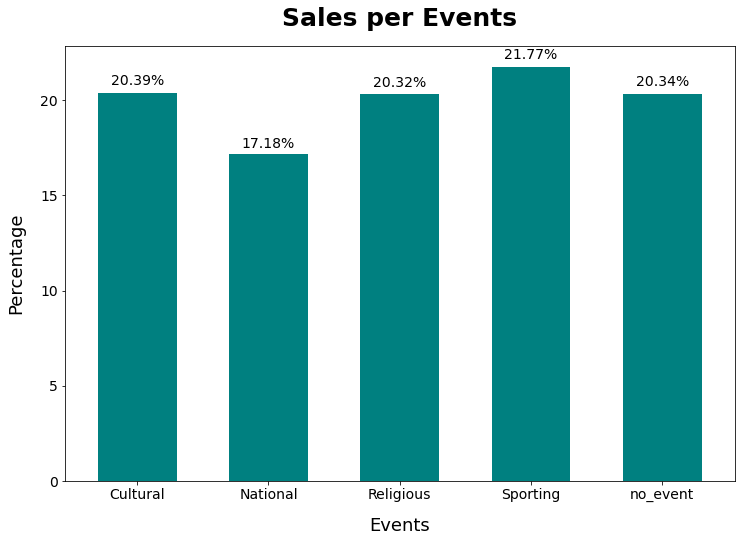

In [36]:
d = df[['event_type_1', 'demand']]
d = d.groupby(by='event_type_1').mean('demand').reset_index()
d['percent'] = np.round(d['demand'] / d['demand'].sum() * 100, 2)
fig, axes = plt.subplots(figsize=(12, 8))
a = d.plot(kind='bar', x='event_type_1', y='percent', width=0.6, ax=axes, color='teal')
patch1(a, axes)
plt.title('Sales per Events', loc='center', fontsize=25, pad='20', fontweight='bold')
axes.set_ylabel('Percentage', fontsize=18, labelpad=15)
axes.set_xlabel('Events', fontsize=18, labelpad=15)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
axes.get_legend().remove()
plt.show()

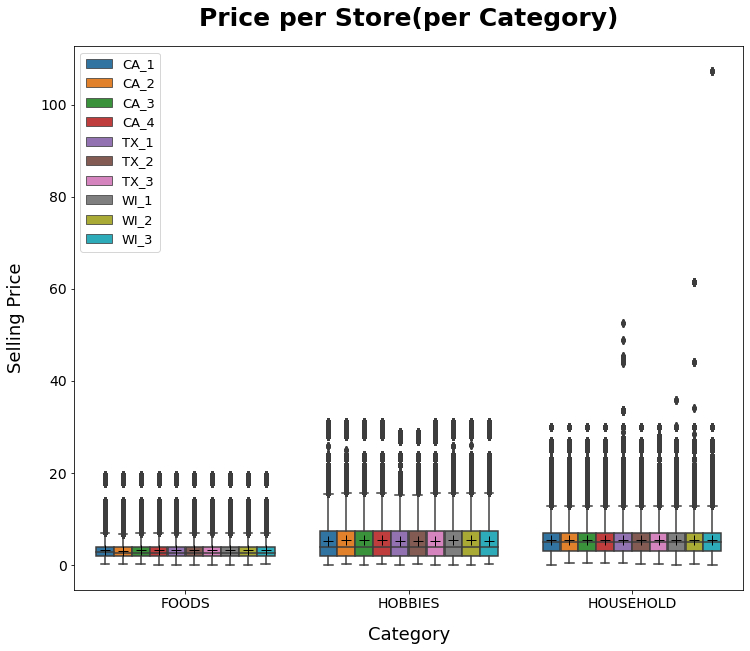

In [37]:
d = df[['cat_id', 'store_id', 'sell_price']]
fig, ax = plt.subplots(figsize=(12, 10))
# https://www.geeksforgeeks.org/how-to-show-mean-on-boxplot-using-seaborn-in-python/
sns.boxplot(x='cat_id', y='sell_price', data=d, showmeans=True, ax=ax,
            meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"}, hue='store_id')
ax.set_ylabel('Selling Price', fontsize=18, labelpad=15)
ax.set_xlabel('Category', fontsize=18, labelpad=15)
ax.set_title('Price per Store(per Category)', loc='center', fontsize=25, pad='20', fontweight='bold')
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
plt.show()

In [39]:
def func1(x, y, z):
    j = 0
    for i in y:
        df1 = df[[x, i]]
        df1[i] = df1[i].div(1e3)
        df1 = df1.groupby(x).sum()
        plt.plot(df1, color=z[j], label=i)
        j += 1

In [40]:
def x1(df, y, ax, color):
    df.plot(x='date', y=y, ax=ax, color=color)
    ax.set_facecolor('black')
    ax.set_xlabel(' ')
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=11)

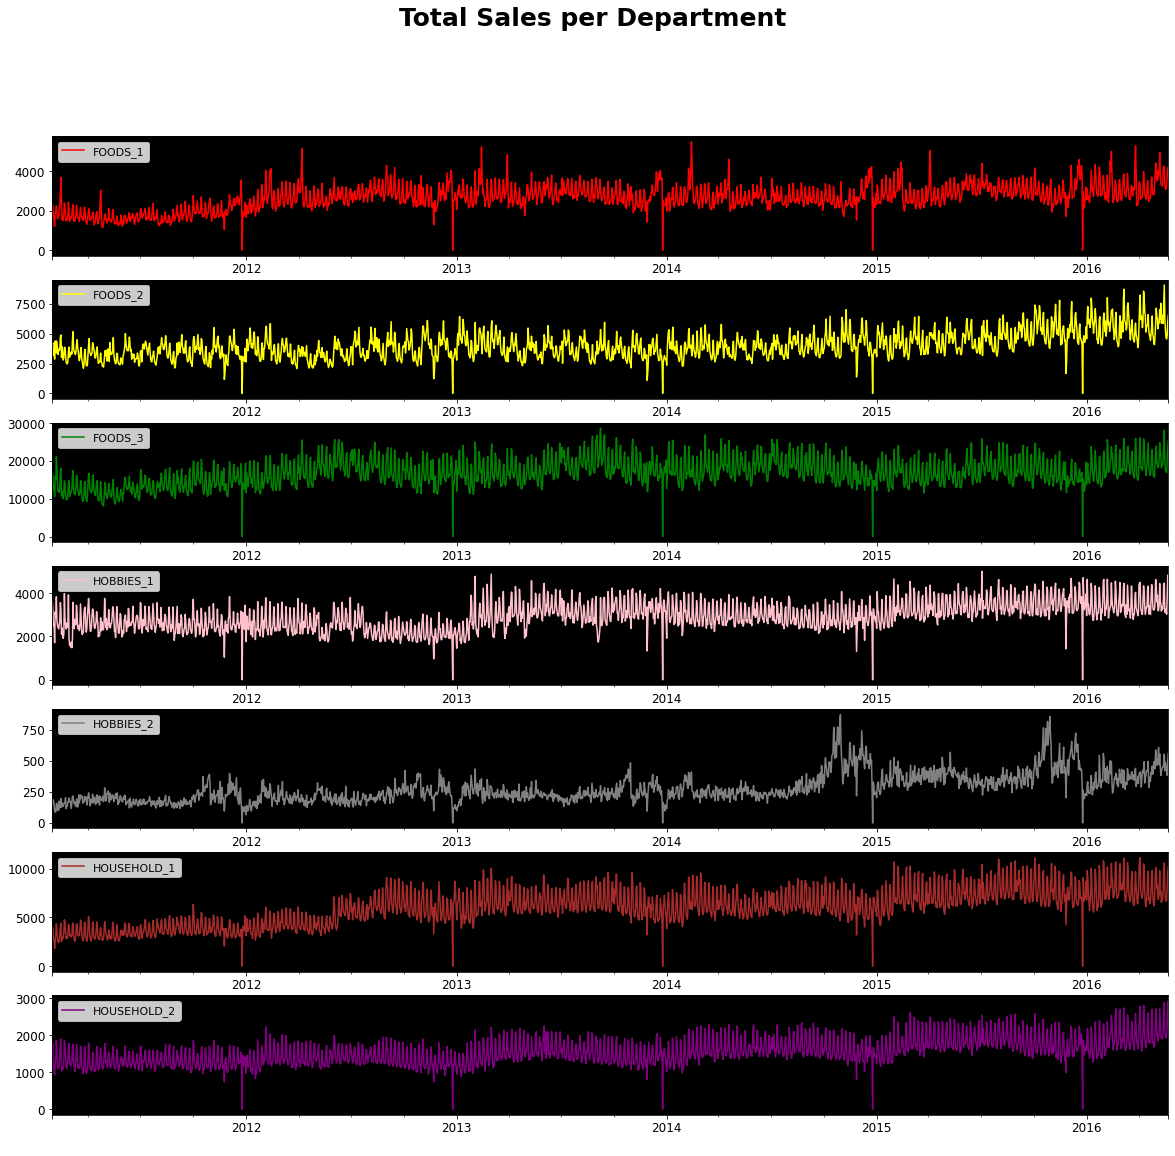

In [41]:
d = sales_train.groupby(['dept_id']).sum().transpose()
# https://stackoverflow.com/questions/60595374/typeerror-cannot-insert-an-item-into-a-categoricalindex-that-is-not-already-an
d.columns = d.columns.add_categories('index')
d = d.reset_index().rename(columns={'index': 'd'})
df = d.merge(calendar[['date', 'd']], on='d')
fig, axes = plt.subplots(7, 1, figsize=(20, 18))
plt.subplots_adjust(wspace=0.25)
fig.suptitle('Total Sales per Department', fontsize=25, fontweight='bold')
x1(df, 'FOODS_1', axes[0], 'red')
x1(df, 'FOODS_2', axes[1], 'yellow')
x1(df, 'FOODS_3', axes[2], 'green')
x1(df, 'HOBBIES_1', axes[3], 'pink')
x1(df, 'HOBBIES_2', axes[4], 'gray')
x1(df, 'HOUSEHOLD_1', axes[5], 'brown')
x1(df, 'HOUSEHOLD_2', axes[6], 'purple')
plt.show()

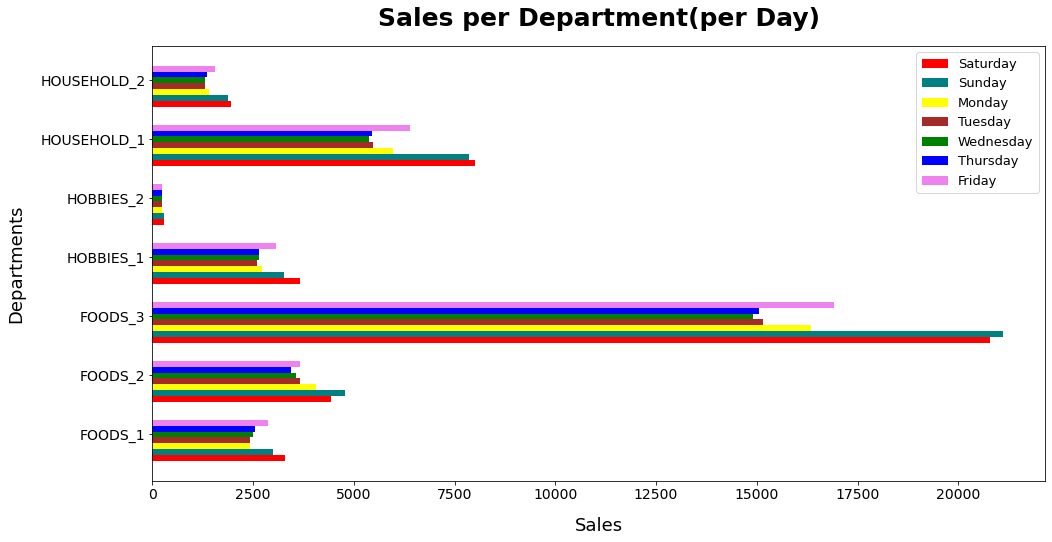

In [42]:
dept = ['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']
labels = dept  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
d = sales_train.groupby(['dept_id']).sum().transpose()
# https://stackoverflow.com/questions/60595374/typeerror-cannot-insert-an-item-into-a-categoricalindex-that-is-not-already-an
d.columns = d.columns.add_categories('index')
d = d.reset_index().rename(columns={'index': 'd'})
df = d.merge(calendar[['wday', 'd']], on='d')
df2 = pd.DataFrame(columns=['wday', 'sales'])
for i in dept:
    df1 = df[[i, 'wday']].groupby(['wday']).median().reset_index().rename({i: 'sales'}, axis=1)
    l = []
    for j in range(7):
        l.append(i)
    df1['dept'] = l
    df2 = pd.concat([df2, df1])
df2 = df2.reset_index().drop(['index'], axis=1)
df3 = df2.groupby(['wday', 'dept']).median().reset_index()
de = []
for i in range(1, 8):
    de.append(df3.loc[df3['wday'] == i]['sales'].tolist())
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
fig, ax = plt.subplots(figsize=(16, 8))
bar1 = ax.barh(x - 0.4, de[0], width, label='Saturday', color='red')
bar2 = ax.barh(x - 0.3, de[1], width, label='Sunday', color='teal')
bar3 = ax.barh(x - 0.2, de[2], width, label='Monday', color='yellow')
bar4 = ax.barh(x - 0.1, de[3], width, label='Tuesday', color='brown')
bar5 = ax.barh(x, de[4], width, label='Wednesday', color='green')
bar6 = ax.barh(x + 0.1, de[5], width, label='Thursday', color='blue')
bar7 = ax.barh(x + 0.2, de[6], width, label='Friday', color='violet')
ax.set_xlabel('Sales', fontsize=18, labelpad=15)
ax.set_ylabel('Departments', fontsize=18, labelpad=15)
ax.set_title('Sales per Department(per Day)', loc='center', fontsize=25, pad='20', fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(fontsize=13)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

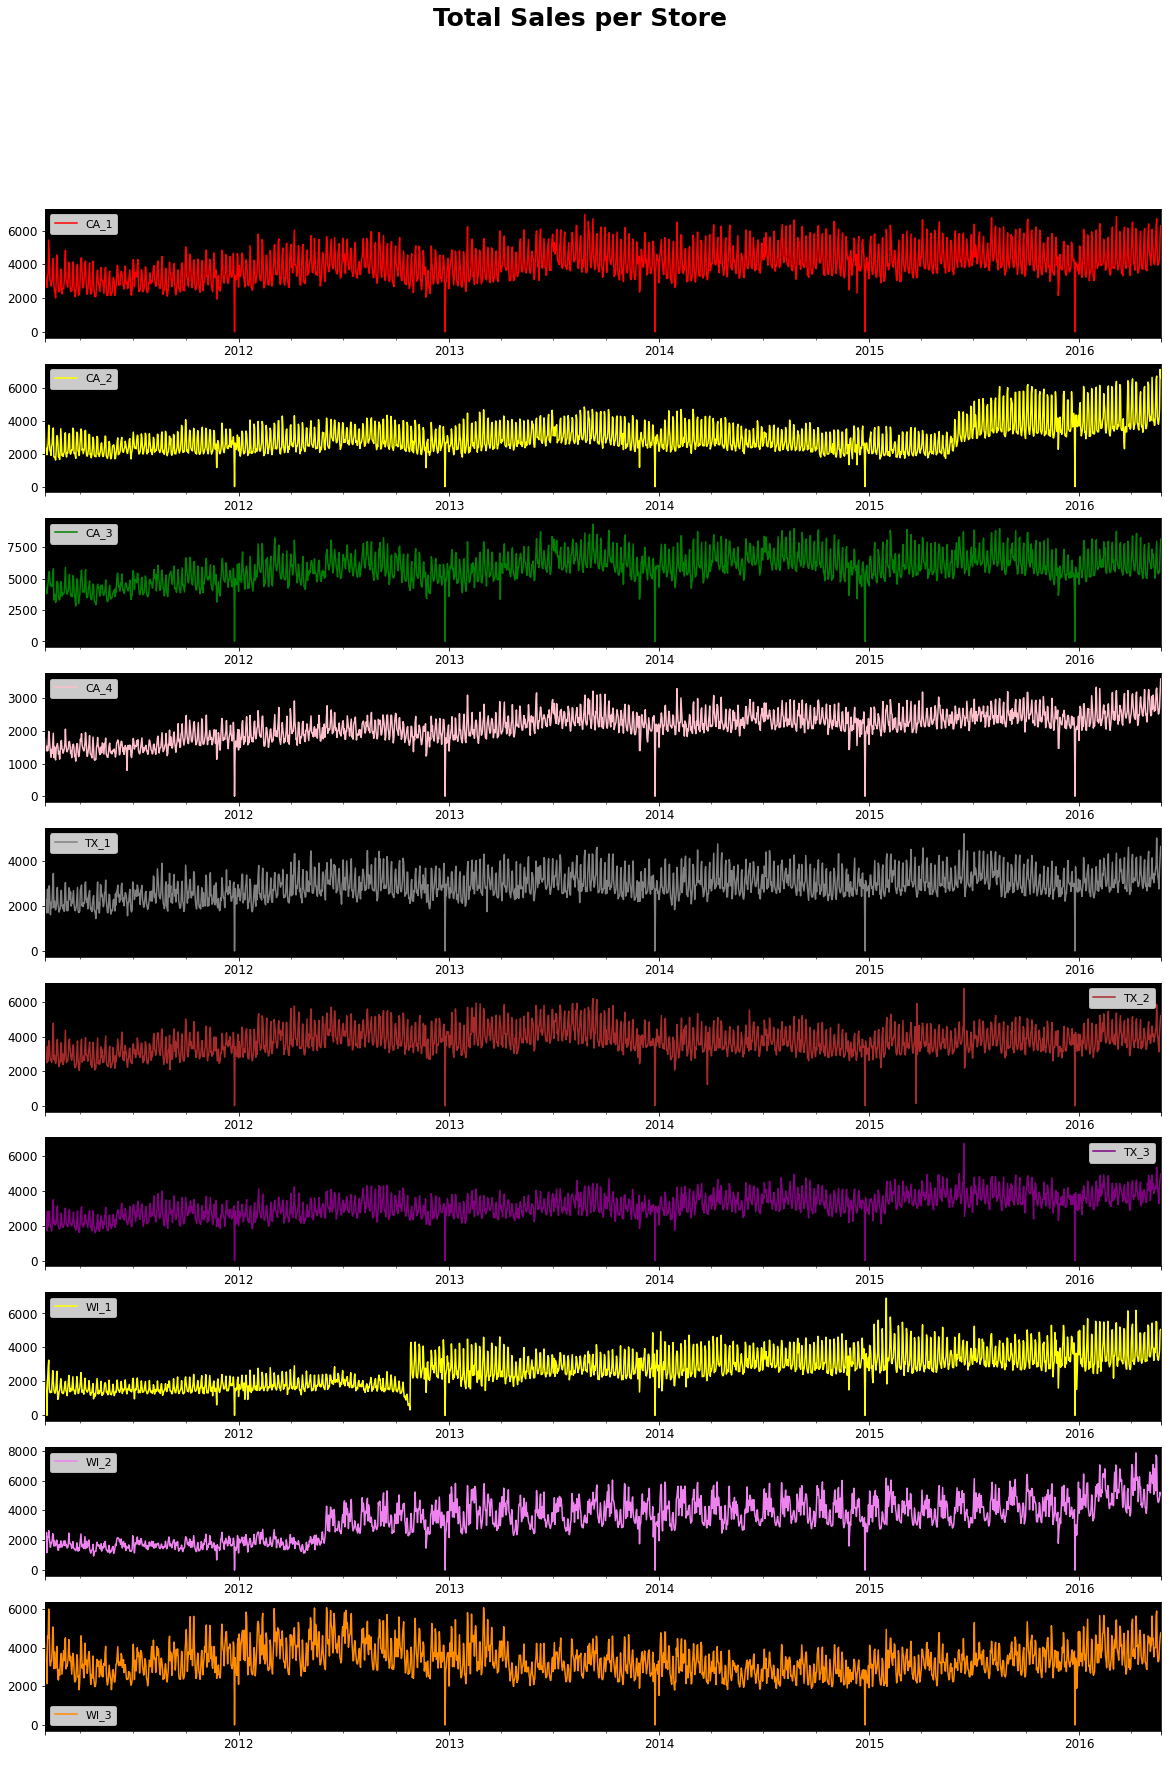

In [44]:
d = sales_train.groupby(['store_id']).sum().transpose()
# https://stackoverflow.com/questions/60595374/typeerror-cannot-insert-an-item-into-a-categoricalindex-that-is-not-already-an
d.columns = d.columns.add_categories('index')
d = d.reset_index().rename(columns={'index': 'd'})
df = d.merge(calendar[['date', 'd']], on='d')
fig, axes = plt.subplots(10, 1, figsize=(20, 28))
fig.suptitle('Total Sales per Store ', fontsize=25, fontweight='bold')
x1(df, 'CA_1', axes[0], 'red')
x1(df, 'CA_2', axes[1], 'yellow')
x1(df, 'CA_3', axes[2], 'green')
x1(df, 'CA_4', axes[3], 'pink')
x1(df, 'TX_1', axes[4], 'gray')
x1(df, 'TX_2', axes[5], 'brown')
x1(df, 'TX_3', axes[6], 'purple')
x1(df, 'WI_1', axes[7], 'yellow')
x1(df, 'WI_2', axes[8], 'violet')
x1(df, 'WI_3', axes[9], 'darkorange')
plt.show()